Minimal example of Bernoulli used in 1D Gaussian Mixture model, with AutoNormal guide and enumeration used for inference.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoHierarchicalNormalMessenger, AutoNormal
from pyro.infer import SVI, Trace_ELBO, infer_discrete, config_enumerate
from pyro.infer import Predictive
from pyro.poutine import block
from pyro.infer.autoguide.initialization import init_to_value
import pandas as pd
import tqdm

from pytorch_lightning import seed_everything
seed_everything(0)

Global seed set to 0


0

Load test data:

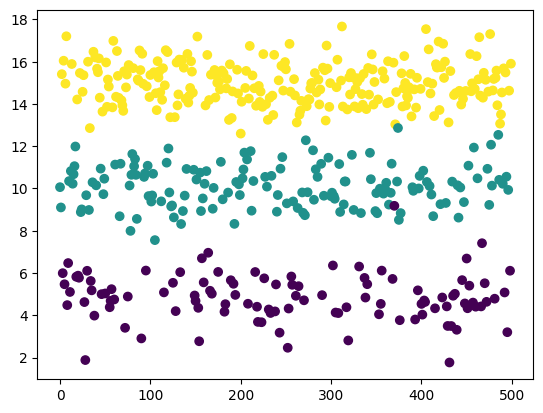

In [2]:
n_components = 3
n_observations = 500
tab = pd.read_csv('testData.csv')
data = torch.tensor(tab['data'], dtype = torch.float32)
b = torch.tensor(tab['b'].astype(int))
plt.scatter(range(len(data)), data, c = b)

Our model using the Cateogorical distribution to assign observations to components:

In [3]:
import numpy as np
import pyro
import pyro.distributions as dist
import torch
from pyro.infer.autoguide.utils import deep_getattr, deep_setattr
from pyro.nn import PyroModule, PyroSample

class ClassSampler(PyroModule):
    """
    Sample class probabilities.

    Uses Gumbel-softmax to sample from a categorical distribution over the switch dimension in a cell-specific way.

    """

    def __init__(
        self,
        name: str,
        n_clusters: int,
        n_cells: int,
        temperature: float = 0.1,
        hard_sample: bool = False,
        weights_prior={"shape": 1.0, "scale": 1.0, "informed_scale": 0.2},
    ):
        super().__init__()

        self.name = name

        self.n_clusters = n_clusters
        self.n_cells = n_cells
        self.hard_sample = hard_sample

        self.weights = PyroModule()

        self.register_buffer("ones", torch.ones(1))
        self.register_buffer("zeros", torch.zeros(1))
        self.register_buffer("ten", torch.tensor(10.0))
        self.weights_prior = weights_prior
        self.register_buffer(
            "weights_prior_shape", torch.tensor(float(self.weights_prior["shape"]))
        )
        self.register_buffer(
            "weights_prior_scale", torch.tensor(float(self.weights_prior["scale"]))
        )

        self.register_buffer("temperature", torch.tensor(temperature))

    def forward(
        self,
        obs_plate=None,
    ):
        # generate the per cell cluster probabilities ==========
        weights_name = f"{self.name}_probabilities_unconstrained_cs"
        if obs_plate is not None:
            weights_shape = [1, self.n_clusters]
            probabilities_unconstrained_cs = pyro.sample(
                weights_name,
                dist.SoftLaplace(
                    self.zeros.expand(weights_shape),
                    self.weights_prior_scale.expand(weights_shape),
                )
            )
            n_obs = len(obs_plate)
        else:
            weights_shape = [self.n_cells, self.n_clusters]
            if getattr(self.weights, weights_name, None) is None:
                deep_setattr(
                    self.weights,
                    weights_name,
                    PyroSample(
                        lambda prior: dist.SoftLaplace(
                            self.zeros.expand(weights_shape),
                            self.weights_prior_scale.expand(weights_shape),
                        )
                        .expand(weights_shape)
                        .to_event(len(weights_shape)),
                    ),
                )
            probabilities_unconstrained_cs = deep_getattr(self.weights, weights_name)
            n_obs = self.n_cells
            
        gumbels_cs = (
            -torch.empty(
                [n_obs, self.n_clusters],
            )
            .exponential_()
            .log()
        )  # ~Gumbel(0,1)
        gumbels_cs = (
            probabilities_unconstrained_cs + gumbels_cs
        ) / self.temperature  # ~Gumbel(logits,tau)
        probabilities_cs = torch.softmax(
            gumbels_cs,
            dim=-1,
        )
        pyro.deterministic('b', torch.softmax(
            probabilities_unconstrained_cs / self.temperature,
            dim=-1,
        ))

        if self.hard_sample:
            # Straight through.
            index = probabilities_cs.max(dim=-1, keepdim=True)[1]
            switch_choice_cs = torch.zeros_like(probabilities_cs).scatter_(
                -1, index, 1.0
            )
            switch_choice_cs = (
                switch_choice_cs - probabilities_cs.detach() + probabilities_cs
            )
        else:
            # Reparametrization trick.
            switch_choice_cs = probabilities_cs

        return switch_choice_cs


In [4]:
def model(data, n_components, n_observations, i):
    mus = pyro.sample('mus', dist.Gamma(20,2).expand([n_components]).to_event(1))
    b = ClassSampler(
            name='class_probability',
            n_clusters=n_components,
            n_cells=n_observations,
            temperature=0.1,
            hard_sample=False,
    )()
    mean = b @ mus.reshape([n_components, 1])
    pyro.sample("data_target", dist.Normal(loc = mean.flatten(), scale = torch.tensor(1.)).to_event(1), obs = data)

Define custom guide:

In [5]:
# Make appropriate auto guide
guide = AutoHierarchicalNormalMessenger(model)

Training:

In [6]:
# Train model:
n_iterations = 4000
optim = pyro.optim.Adam({'lr': 0.01})
elbo = Trace_ELBO()
svi = SVI(model, guide, optim, loss=elbo)
for i in tqdm.auto.tqdm(range(n_iterations)):
    loss = svi.step(data, n_components, n_observations, i)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [7]:
# Predict components:
# posterior = Predictive(model, guide=guide, num_samples=1000)(data, n_components, n_observations, i)
# b_inferred_ = posterior['b'].mean(0).detach().numpy().argmax(1)
b_inferred_ = guide.median(data, n_components, n_observations, i)['b'].squeeze().detach().numpy().argmax(1)

Evaluate model (check all permutations of classes):

In [8]:
score = np.zeros(6)
b_inferred = b_inferred_.copy()
score[0] = np.array(torch.sum(b - b_inferred  == 0)/len(b))
b_inferred_switched1 = b_inferred_.copy()
b_inferred_switched1[b_inferred_switched1 == 0] = 1
b_inferred_switched1[b_inferred == 1] = 0
score[1] = np.array(torch.sum(b - b_inferred_switched1  == 0)/len(b))
b_inferred_switched2 = b_inferred_.copy()
b_inferred_switched2[b_inferred_switched2 == 2] = 1
b_inferred_switched2[b_inferred == 1] = 2
score[2] = np.array(torch.sum(b - b_inferred_switched2  == 0)/len(b))
b_inferred_switched3 = b_inferred_.copy()
b_inferred_switched3[b_inferred_switched3 == 0] = 2
b_inferred_switched3[b_inferred == 2] = 0
score[3] = np.array(torch.sum(b - b_inferred_switched3  == 0)/len(b))
b_inferred_switched4 = b_inferred_.copy()
b_inferred_switched4[b_inferred_switched4 == 0] = 1
b_inferred_switched4[b_inferred == 1] = 0
subset = b_inferred_switched4 == 2
b_inferred_switched4[b_inferred_switched4 == 0] = 2
b_inferred_switched4[subset] = 0
score[4] = np.array(torch.sum(b - b_inferred_switched4  == 0)/len(b))
b_inferred_switched5 = b_inferred_.copy()
b_inferred_switched5[b_inferred_switched5 == 0] = 2
b_inferred_switched5[b_inferred == 2] = 0
subset = b_inferred_switched5 == 1
b_inferred_switched5[b_inferred_switched5 == 0] = 1
b_inferred_switched5[subset] = 0
score[5] = np.array(torch.sum(b - b_inferred_switched5  == 0)/len(b))

In [9]:
print('Percentage correctly classified: ', np.max(score))

Percentage correctly classified:  0.9580000042915344


Inferred classes:

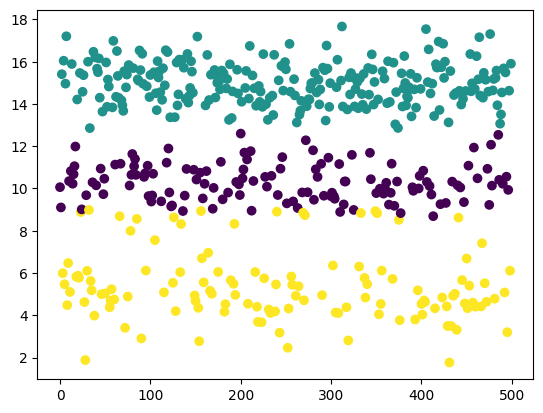

In [10]:
plt.scatter(range(len(data)), data, c = b_inferred)

True classes:

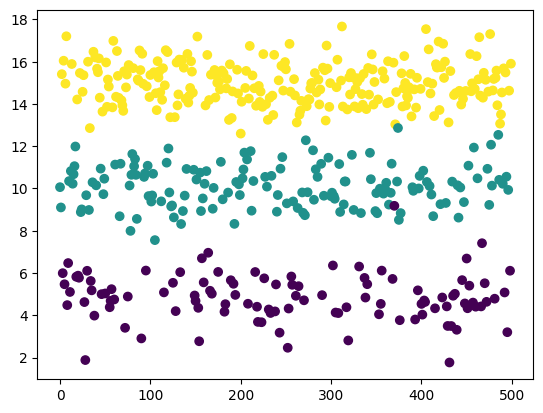

In [11]:
plt.scatter(range(len(data)), data, c = b)